# Ben Eberle Term Project

# Introduction
The Framingham Heart Study is a long-term, ongoing cardiovascular cohort study of residents of the city of Framingham, Massachusetts. The study began in 1948 with 5,209 adult subjects from Framingham, and is now on its third generation of participants. The dataset that I am using has 16 attributes per participant including gender, age, education, number of cigerettes per day, cholesterol, blood pressure and more. My goals for this projects are as follows:<br>
1. Build Neural Network with Optimizers
2. Partition Framingham Heart Disease Dataset into Training and Testing sets
3. Classify Patients by 10YearCHD
4. Predict Glucose Level using Regression

Link to notebook - https://www.kaggle.com/amanajmera1/framingham-heart-study-dataset
<br>In this notebook I have used code from CS445 notebook 7.2, A2, A3 and A4.

# NeuralNetwork Setup

In [146]:
import matplotlib.pyplot as plt

In [148]:
import numpy as np
import optimizers
import sys  # for sys.float_info.epsilon

######################################################################
## class NeuralNetwork()
######################################################################

class NeuralNetwork():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function='tanh'):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.activation_function = activation_function

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs}, \'{self.activation_function}\')'


    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        result = self.__repr__()
        if len(self.error_trace) > 0:
            return self.__repr__() + f' trained for {len(self.error_trace)} epochs, final training error {self.error_trace[-1]:.4f}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):
        '''
train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = optimizers.Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units, 
        # but only if the network has a single output. Multiplying by self.Tstds for 
        # multiple outputs does not correctly unstandardize the error.
        if len(self.Tstds) == 1:
            error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar
        else:
            error_convert_f = lambda err: np.sqrt(err)[0] # to scalar
            

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=True,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         verbose=True,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self

    def relu(self, s):
        s[s < 0] = 0
        return s

    def grad_relu(self, s):
        return (s > 0).astype(int)
    
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        for W in self.Ws[:-1]:
            if self.activation_function == 'relu':
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            else:
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            if self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
            else:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

    def use(self, X):
        '''X assumed to not be standardized'''
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        Ys = self.forward_pass(X)
        Y = Ys[-1]
        # Unstandardize output Y before returning it
        return Y * self.Tstds + self.Tmeans

In [149]:
def generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

    if shuffle:
        # Randomly order X and T
        randorder = np.arange(X.shape[0])
        np.random.shuffle(randorder)
        X = X[randorder, :]
        T = T[randorder, :]

    # Partition X and T into folds
    n_samples = X.shape[0]
    n_per_fold = round(n_samples / n_folds)
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )

    # Yield k(k-1) assignments of Xtrain, Train, Xvalidate, Tvalidate, Xtest, Ttest

    for validation_i in range(n_folds):
        for test_i in range(n_folds):
            if test_i == validation_i:
                continue

            train_i = np.setdiff1d(range(n_folds), [validation_i, test_i])

            Xvalidate, Tvalidate = folds[validation_i]
            Xtest, Ttest = folds[test_i]
            if len(train_i) > 1:
                Xtrain = np.vstack([folds[i][0] for i in train_i])
                Ttrain = np.vstack([folds[i][1] for i in train_i])
            else:
                Xtrain, Ttrain = folds[train_i[0]]

            yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

# Classification
The classification portion of my project is focused on classifiying patents by the 10yearCHD attribute which is an indicator of a participants 10 year risk of Coronary Heart Disease. The 10yearCHD attribute is presented as a binary value, 0 or 1.

In [151]:
class NeuralNetworkClassifier(NeuralNetwork):
        
    
    def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):
        '''
train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''
        T = self.makeIndicatorVars(T)

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = optimizers.Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units, 
        # but only if the network has a single output. Multiplying by self.Tstds for 
        # multiple outputs does not correctly unstandardize the error.
        if len(self.Tstds) == 1:
            error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar
        else:
            error_convert_f = lambda err: np.sqrt(err) # to scalar
            

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=True,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         verbose=True,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self
        
        
    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        Ys = self.softmax(Ys[-1])
        return np.exp(np.mean(T * np.log(Ys)))
    
        
    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.softmax(self.Ys[-1])
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            if self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
            else:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients
    
    
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        for W in self.Ws[:-1]:
            if self.activation_function == 'relu':
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            else:
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys
    
    
    def use(self, X):
        '''X assumed to not be standardized'''
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        Ys = self.forward_pass(X)
        Y = Ys[-1]
        logregOutput = self.softmax(Y)
        predicted = np.argmax(logregOutput,axis=1)
        classes = np.unique(T)[np.argmax(Y, axis=1)].reshape(-1, 1)
        return classes, predicted
    
    
    def softmax(self, X):
        fs = np.exp(X)  # N x K
        denom = np.sum(fs, axis=1).reshape((-1, 1))
        gs = fs / denom
        return gs


    def makeIndicatorVars(self, T):
        # Make sure T is two-dimensional. Should be nSamples x 1.
        if T.ndim == 1:
            T = T.reshape((-1, 1))    
        return (T == np.unique(T)).astype(int)


  

In [152]:
import pandas
df = pandas.read_csv('framingham_heart_disease.csv', na_values='NA')
df = df.dropna()
X = df.iloc[:, :-1].values
T = df.iloc[:, -1:].values
df

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4231,1,58,3.0,0,0.0,0.0,0,1,0,187.0,141.0,81.0,24.96,80.0,81.0,0
4232,1,68,1.0,0,0.0,0.0,0,1,0,176.0,168.0,97.0,23.14,60.0,79.0,1
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0


CLASSES
[0 1]
Adam: Epoch 5 Error=0.86438
Adam: Epoch 10 Error=0.87322
Adam: Epoch 15 Error=0.88317
Adam: Epoch 20 Error=0.89310
Adam: Epoch 25 Error=0.90122
Adam: Epoch 30 Error=0.90670
Adam: Epoch 35 Error=0.90913
Adam: Epoch 40 Error=0.90964
Adam: Epoch 45 Error=0.90963
Adam: Epoch 50 Error=0.90985


Text(0, 0.5, 'Likelihood')

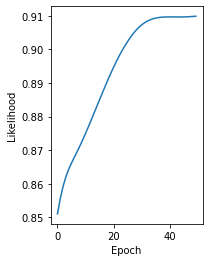

In [153]:
hiddens = [10]
print('CLASSES')
print(np.unique(T))
nnet = NeuralNetworkClassifier(X.shape[1], hiddens, len(np.unique(T)))
nnet.train(X, T, 50, 0.01, method='adam', verbose=True)

plt.subplot(1, 2, 1)
plt.plot(nnet.error_trace)
plt.xlabel('Epoch')
plt.ylabel('Likelihood')

In [154]:
for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, 3):
    print()
    #print('Xtrain\n', Xtrain)
    #print('Ttrain\n', Ttrain)
    #print('Xvalidate\n', Xvalidate)
    #print('Tvalidate\n', Tvalidate)
    #print('Xtest\n', Xtest)
    #print('Ttest\n', Ttest)
print(Xtrain.shape, Ttrain.shape,  Xvalidate.shape, Tvalidate.shape,  Xtest.shape, Ttest.shape)

classes = np.arange(2)
(Ttrain == classes).shape

n_epochs = 10000
learning_rate = 0.01

np.random.seed(142)

nnet = NeuralNetworkClassifier(Xtrain.shape[1], [20], len(classes))
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', verbose=True)







(1219, 15) (1219, 1) (1218, 15) (1218, 1) (1219, 15) (1219, 1)
Adam: Epoch 1000 Error=0.99242
Adam: Epoch 2000 Error=0.99770
Adam: Epoch 3000 Error=0.99899
Adam: Epoch 4000 Error=0.99938
Adam: Epoch 5000 Error=0.99972
Adam: Epoch 6000 Error=0.99988
Adam: Epoch 7000 Error=0.99994
Adam: Epoch 8000 Error=0.99996
Adam: Epoch 9000 Error=0.99998
Adam: Epoch 10000 Error=0.99999


NeuralNetworkClassifier(15, [20], 2, 'tanh')

NeuralNetworkClassifier(15, [20], 2, 'tanh') trained for 10000 epochs, final training error 1.0000


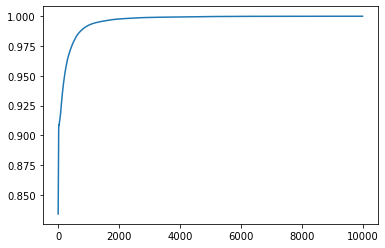

In [155]:
print(nnet)
plt.plot(nnet.error_trace);

# Classification Observations
As we can see in the graph above our model did not need very many epochs to begin effectivly classifying participants into the 10yearCHD category. If we train the network for only 50 epochs we can see that around 25 epochs the likelyhood of predicting a patents 10yearCHD begins to level off and grow steadily from there. This is suprising to me but could be an indicator of a strong correlation between the chosen attributes for the study and an obvious side effect of the dataset I have chosen. "Of course the attributes are strongly correlated, years of research have shown that these attributes are important and doctors/researchers use them for studying coronary heart disease." If we increase the size of the network and the number of epochs we can get the network to classify with 100% accuracy. 

# NonLinear Regression
For the regression portion of my project, I am going to use my model to predict participant glucose level. I have removed the 10yeardCHD attribute so this network will be trained using only 14 attributes. Below I will be running an experiment similar to the one run in notebook 7.2 "Optimizers, Data Partitioning, Finding Good Parameters" in which we compare the performance of different network architectures.

In [160]:
X = df.iloc[:, :-2].values     #Partition data for new experiment
T = df.iloc[:, -2:-1].values
print(X)
print(T)
print(X.shape, T.shape)

[[ 1.   39.    4.   ... 70.   26.97 80.  ]
 [ 0.   46.    2.   ... 81.   28.73 95.  ]
 [ 1.   48.    1.   ... 80.   25.34 75.  ]
 ...
 [ 1.   50.    1.   ... 92.   25.97 66.  ]
 [ 1.   51.    3.   ... 80.   19.71 65.  ]
 [ 0.   52.    2.   ... 83.   21.47 80.  ]]
[[ 77.]
 [ 76.]
 [ 70.]
 ...
 [ 86.]
 [ 68.]
 [107.]]
(3656, 14) (3656, 1)


In [159]:
#Generate new sets
for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, 3):
    print()
    print('Xtrain\n', Xtrain)
    print('Ttrain\n', Ttrain)
    print('Xvalidate\n', Xvalidate)
    print('Tvalidate\n', Tvalidate)
    print('Xtest\n', Xtest)
    print('Ttest\n', Ttest)
print(Xtrain.shape, Ttrain.shape,  Xvalidate.shape, Tvalidate.shape,  Xtest.shape, Ttest.shape)



Xtrain
 [[  1.    51.     1.   ... 104.    34.97  90.  ]
 [  1.    38.     4.   ...  74.    21.19  65.  ]
 [  0.    42.     3.   ...  91.5   27.78  95.  ]
 ...
 [  0.    47.     4.   ...  61.    20.32  84.  ]
 [  1.    51.     4.   ...  80.    19.36  60.  ]
 [  0.    44.     1.   ...  68.    32.82  88.  ]]
Ttrain
 [[ 65.]
 [ 89.]
 [ 74.]
 ...
 [110.]
 [ 66.]
 [ 80.]]
Xvalidate
 [[  0.    52.     2.   ...  89.    25.37 115.  ]
 [  0.    43.     2.   ...  81.    21.85  70.  ]
 [  0.    63.     1.   ...  81.    31.71  64.  ]
 ...
 [  1.    47.     4.   ...  84.    19.14  68.  ]
 [  0.    51.     1.   ...  79.    26.91  84.  ]
 [  0.    62.     1.   ...  75.    22.91  58.  ]]
Tvalidate
 [[84.]
 [72.]
 [80.]
 ...
 [74.]
 [76.]
 [80.]]
Xtest
 [[ 0.   63.    1.   ... 82.   25.58 78.  ]
 [ 0.   40.    2.   ... 72.   29.62 85.  ]
 [ 0.   41.    1.   ... 93.   35.42 68.  ]
 ...
 [ 0.   61.    1.   ... 76.   31.13 71.  ]
 [ 1.   57.    3.   ... 80.   26.56 75.  ]
 [ 1.   50.    4.   ... 78.   26

In [158]:
results = []
for rate in [0.01]: # learning rates
    for epochs in [1000, 5000]: # Training durations
        for nh in [[0], [10], [50, 10]]: # Layer sizes
            for method in ['adam', 'sgd']: # Optimizers
                # instantiate and train
                nnet = NeuralNetwork(Xtrain.shape[1], nh, Ttrain.shape[1])
                nnet.train(Xtrain, Ttrain, epochs, rate, method=method)
                # append the results of each experiment
                results.append([rate, epochs, nh, method,
                                rmse(Ttrain, nnet.use(Xtrain)),
                                rmse(Tvalidate, nnet.use(Xvalidate)),
                                rmse(Ttest, nnet.use(Xtest))])
                # load these into a dataframe and give it some column titles
                df2 = pandas.DataFrame(results, columns=('rate', 'epochs', 'nh', 'method', 'train RMSE',
                                                    'validate RMSE', 'test RMSE'))
            print(df2)  

Adam: Epoch 100 Error=19.29649
Adam: Epoch 200 Error=19.29625
Adam: Epoch 300 Error=19.29625
Adam: Epoch 400 Error=19.29625
Adam: Epoch 500 Error=19.29625
Adam: Epoch 600 Error=19.29625
Adam: Epoch 700 Error=19.29625
Adam: Epoch 800 Error=19.29625
Adam: Epoch 900 Error=19.29625
Adam: Epoch 1000 Error=19.29625
sgd: Epoch 100 Error=20.40215
sgd: Epoch 200 Error=19.49970
sgd: Epoch 300 Error=19.34609
sgd: Epoch 400 Error=19.31343
sgd: Epoch 500 Error=19.30407
sgd: Epoch 600 Error=19.30049
sgd: Epoch 700 Error=19.29880
sgd: Epoch 800 Error=19.29787
sgd: Epoch 900 Error=19.29732
sgd: Epoch 1000 Error=19.29697
   rate  epochs   nh method  train RMSE  validate RMSE  test RMSE
0  0.01    1000  [0]   adam   19.296252      19.024252  18.111886
1  0.01    1000  [0]    sgd   19.296969      19.025493  18.126445
Adam: Epoch 100 Error=18.74709
Adam: Epoch 200 Error=16.97804
Adam: Epoch 300 Error=15.64756
Adam: Epoch 400 Error=14.68312
Adam: Epoch 500 Error=13.22485
Adam: Epoch 600 Error=12.65735
Adam

# NonLinear Regression Observations
My results from the regression experiments are very interesting. As we can see above, the network is not very good at predicting a participants glucose level but shows promissing results as we increase the size of the network. We can also see that in this case adam outperforms sgd by a lot, probably because of the obvious performance advantges of adam. I believe that if I were to train the network for much longer, the overall performance would increase to an acceptable level, however for these smaller network sizes the performace seems to be unacceptable and unreliable.

# References
1. Framingham Heart Disease Dataset - https://www.kaggle.com/amanajmera1/framingham-heart-study-dataset
2. CS445 Notebook 7.2
3. CS445 A2
4. CS445 A3
5. CS445 A4